In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline


import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
# !pip install yfinance --upgrade --no-cache-dir

In [2]:

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df = pdr.get_data_yahoo("AAPL", start="2010-01-01")
df.to_csv('output/AAPL.csv')
print(df.shape)
df.head()

[*********************100%***********************]  1 of 1 downloaded
(2436, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.49,30.64,30.34,30.57,26.68,123432400
2010-01-05,30.66,30.80,30.46,30.63,26.73,150476200
2010-01-06,30.63,30.75,30.11,30.14,26.30,138040000
2010-01-07,30.25,30.29,29.86,30.08,26.25,119282800
2010-01-08,30.04,30.29,29.87,30.28,26.43,111902700


In [3]:
df = pd.read_csv('output/AAPL.csv')
df.set_index('Date', inplace=True)
print(df.shape)   #(2436, 6)
df.head()

(2436, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.49,30.64,30.34,30.57,26.68,123432400
2010-01-05,30.66,30.80,30.46,30.63,26.73,150476200
2010-01-06,30.63,30.75,30.11,30.14,26.30,138040000
2010-01-07,30.25,30.29,29.86,30.08,26.25,119282800
2010-01-08,30.04,30.29,29.87,30.28,26.43,111902700


In [4]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-30,208.74,21143400,1.556961,-0.675676
2019-09-03,205.70,20023000,1.341760,-0.353631
2019-09-04,209.19,19188100,1.032554,0.383896
2019-09-05,213.28,23913700,1.153413,0.603774
2019-09-06,213.26,19350800,0.895620,-0.369073


In [5]:
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

(2436, 4)
Dimension of X (2411, 4)
Dimension of y (2411,)


In [6]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# Lasso
clflso = Lasso(alpha=0.01)
clflso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
# check confidence
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidencelasso = clflso.score(X_test,y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The lasso regression confidence is ",confidencelasso)

The linear regression confidence is  0.9711236856811443
The quadratic regression 2 confidence is  0.9706796734482129
The quadratic regression 3 confidence is  0.9722102071240786
The lasso regression confidence is  0.9711222558505928


In [9]:
# Linear regression predictions
clf = clfreg  
dfc = dfreg  
forecast_set = clf.predict(X_lately)
dfc['Forecast'] = np.nan

last_date = dfc.iloc[-1].name
forecast_days = forecast_out *7/5

fc_idx = int(len(dfc)-forecast_out)
fc_unix = dfc.iloc[int(fc_idx)].name

for i in forecast_set:
    next_date = dfc.iloc[int(fc_idx)].name
    dfc.loc[next_date] = [np.nan for _ in range(len(dfc.columns)-1)]+[i]
    fc_idx += 1

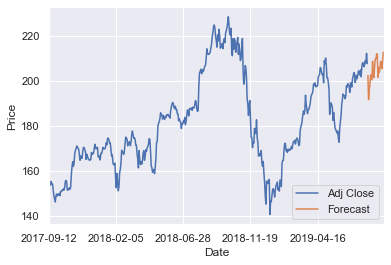

In [10]:
# Plotting Linear regression
dfc['Adj Close'].tail(500).plot() 
dfc['Forecast'].tail(500).plot()  
plt.rcParams["figure.figsize"] = (40,20)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [11]:
# Quadratic Regression 2 predictions
clf = clfpoly2 
dfc = dfreg
forecast_set = clf.predict(X_lately)
dfc['Forecast'] = np.nan

last_date = dfc.iloc[-1].name
forecast_days = forecast_out *7/5

fc_idx = int(len(dfc)-forecast_out)
fc_unix = dfc.iloc[int(fc_idx)].name

for i in forecast_set:
    next_date = dfc.iloc[int(fc_idx)].name
    dfc.loc[next_date] = [np.nan for _ in range(len(dfc.columns)-1)]+[i]
    fc_idx += 1

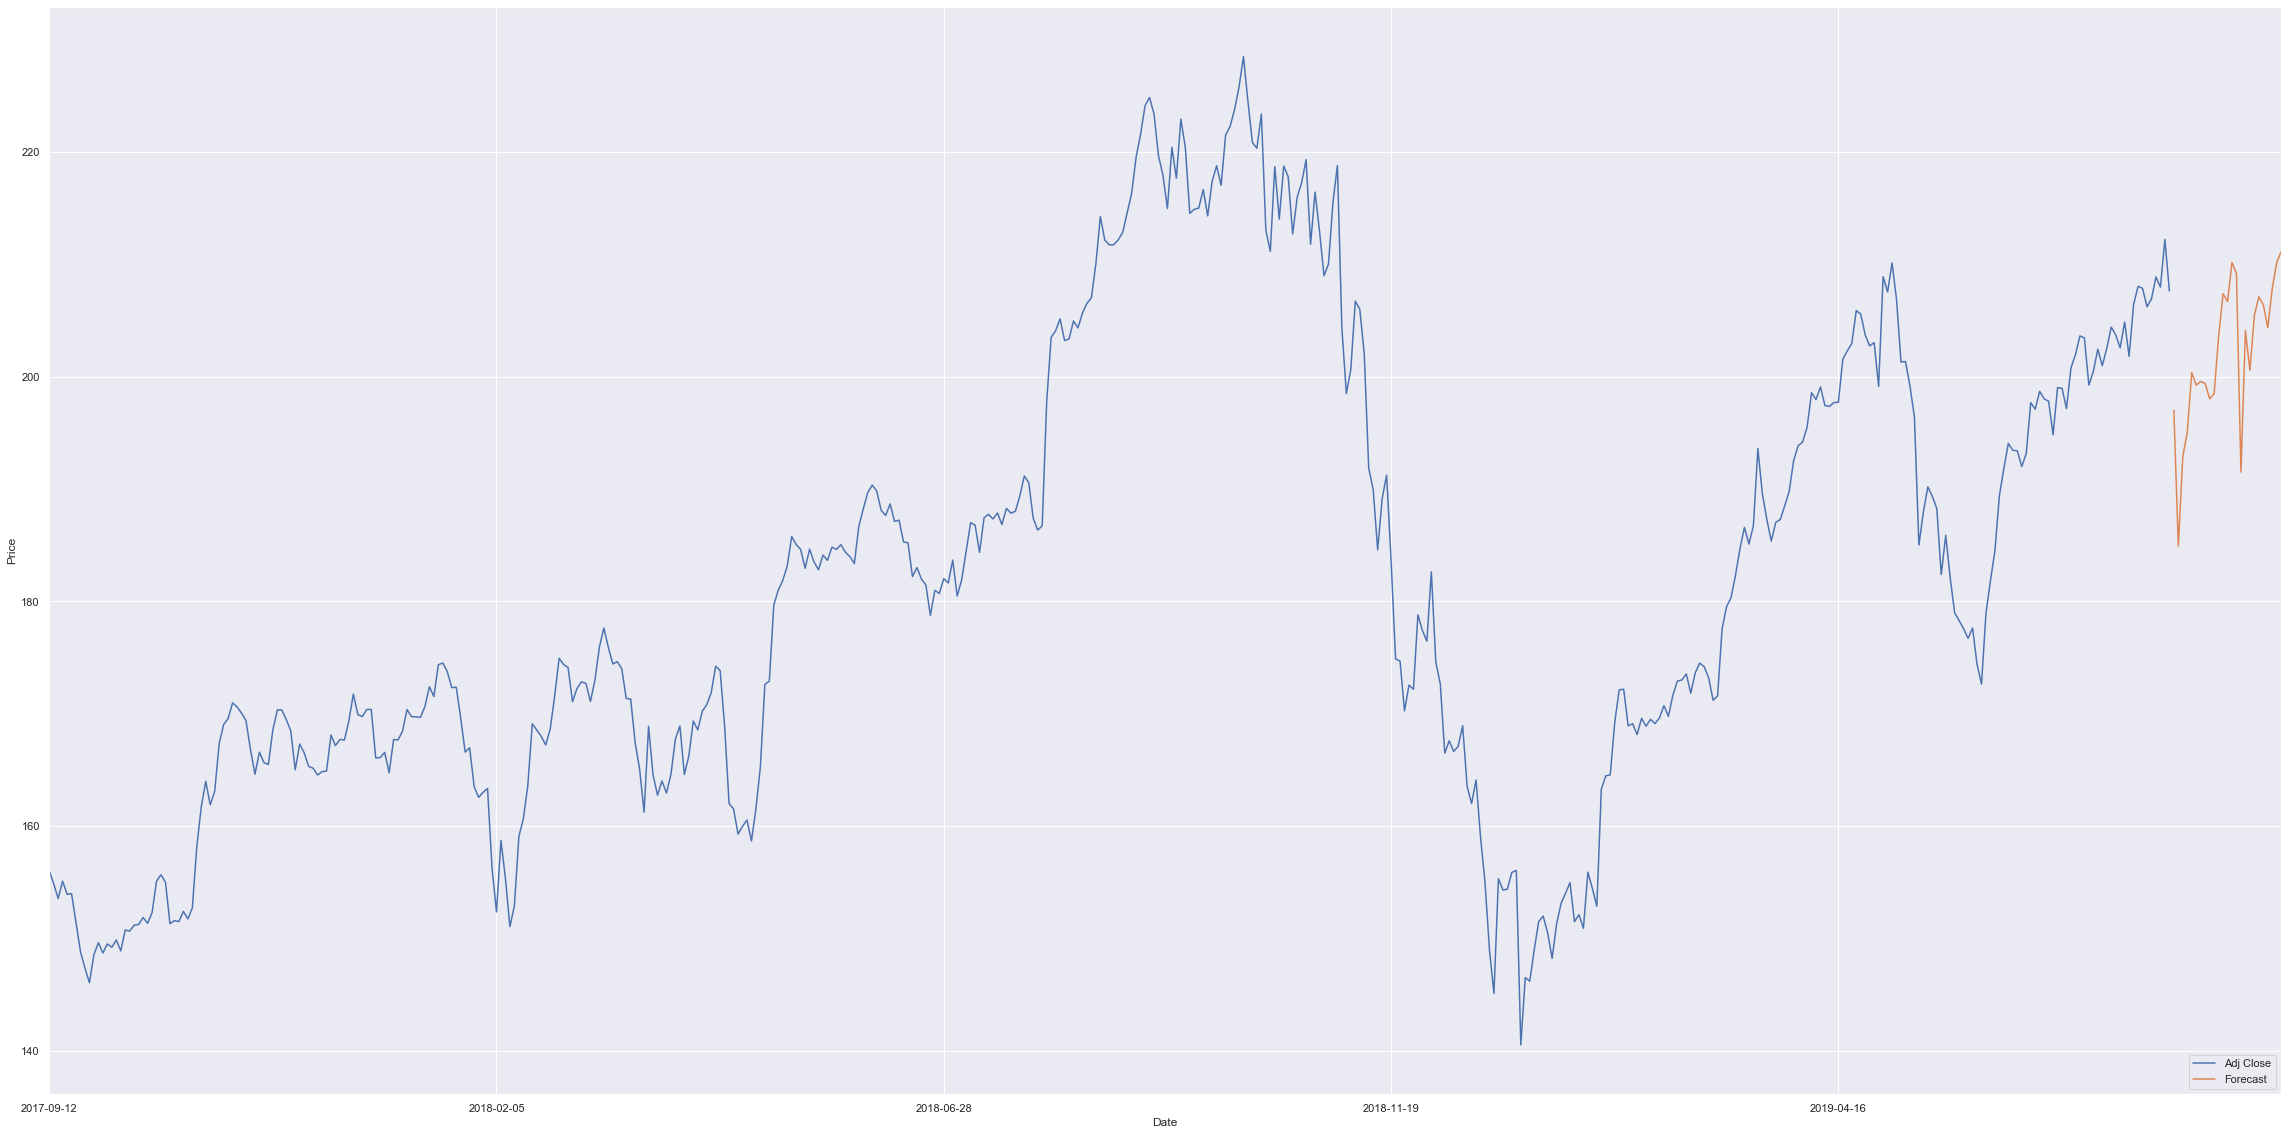

In [12]:
# Plotting Quadratic Regression 2
dfc['Adj Close'].tail(500).plot() 
dfc['Forecast'].tail(500).plot()  
plt.rcParams["figure.figsize"] = (40,20)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [13]:
# Quadratic Regression 3 predictions
clf = clfpoly3
dfc = dfreg
forecast_set = clf.predict(X_lately)
dfc['Forecast'] = np.nan

last_date = dfc.iloc[-1].name
forecast_days = forecast_out *7/5

fc_idx = int(len(dfc)-forecast_out)
fc_unix = dfc.iloc[int(fc_idx)].name

for i in forecast_set:
    next_date = dfc.iloc[int(fc_idx)].name
    dfc.loc[next_date] = [np.nan for _ in range(len(dfc.columns)-1)]+[i]
    fc_idx += 1

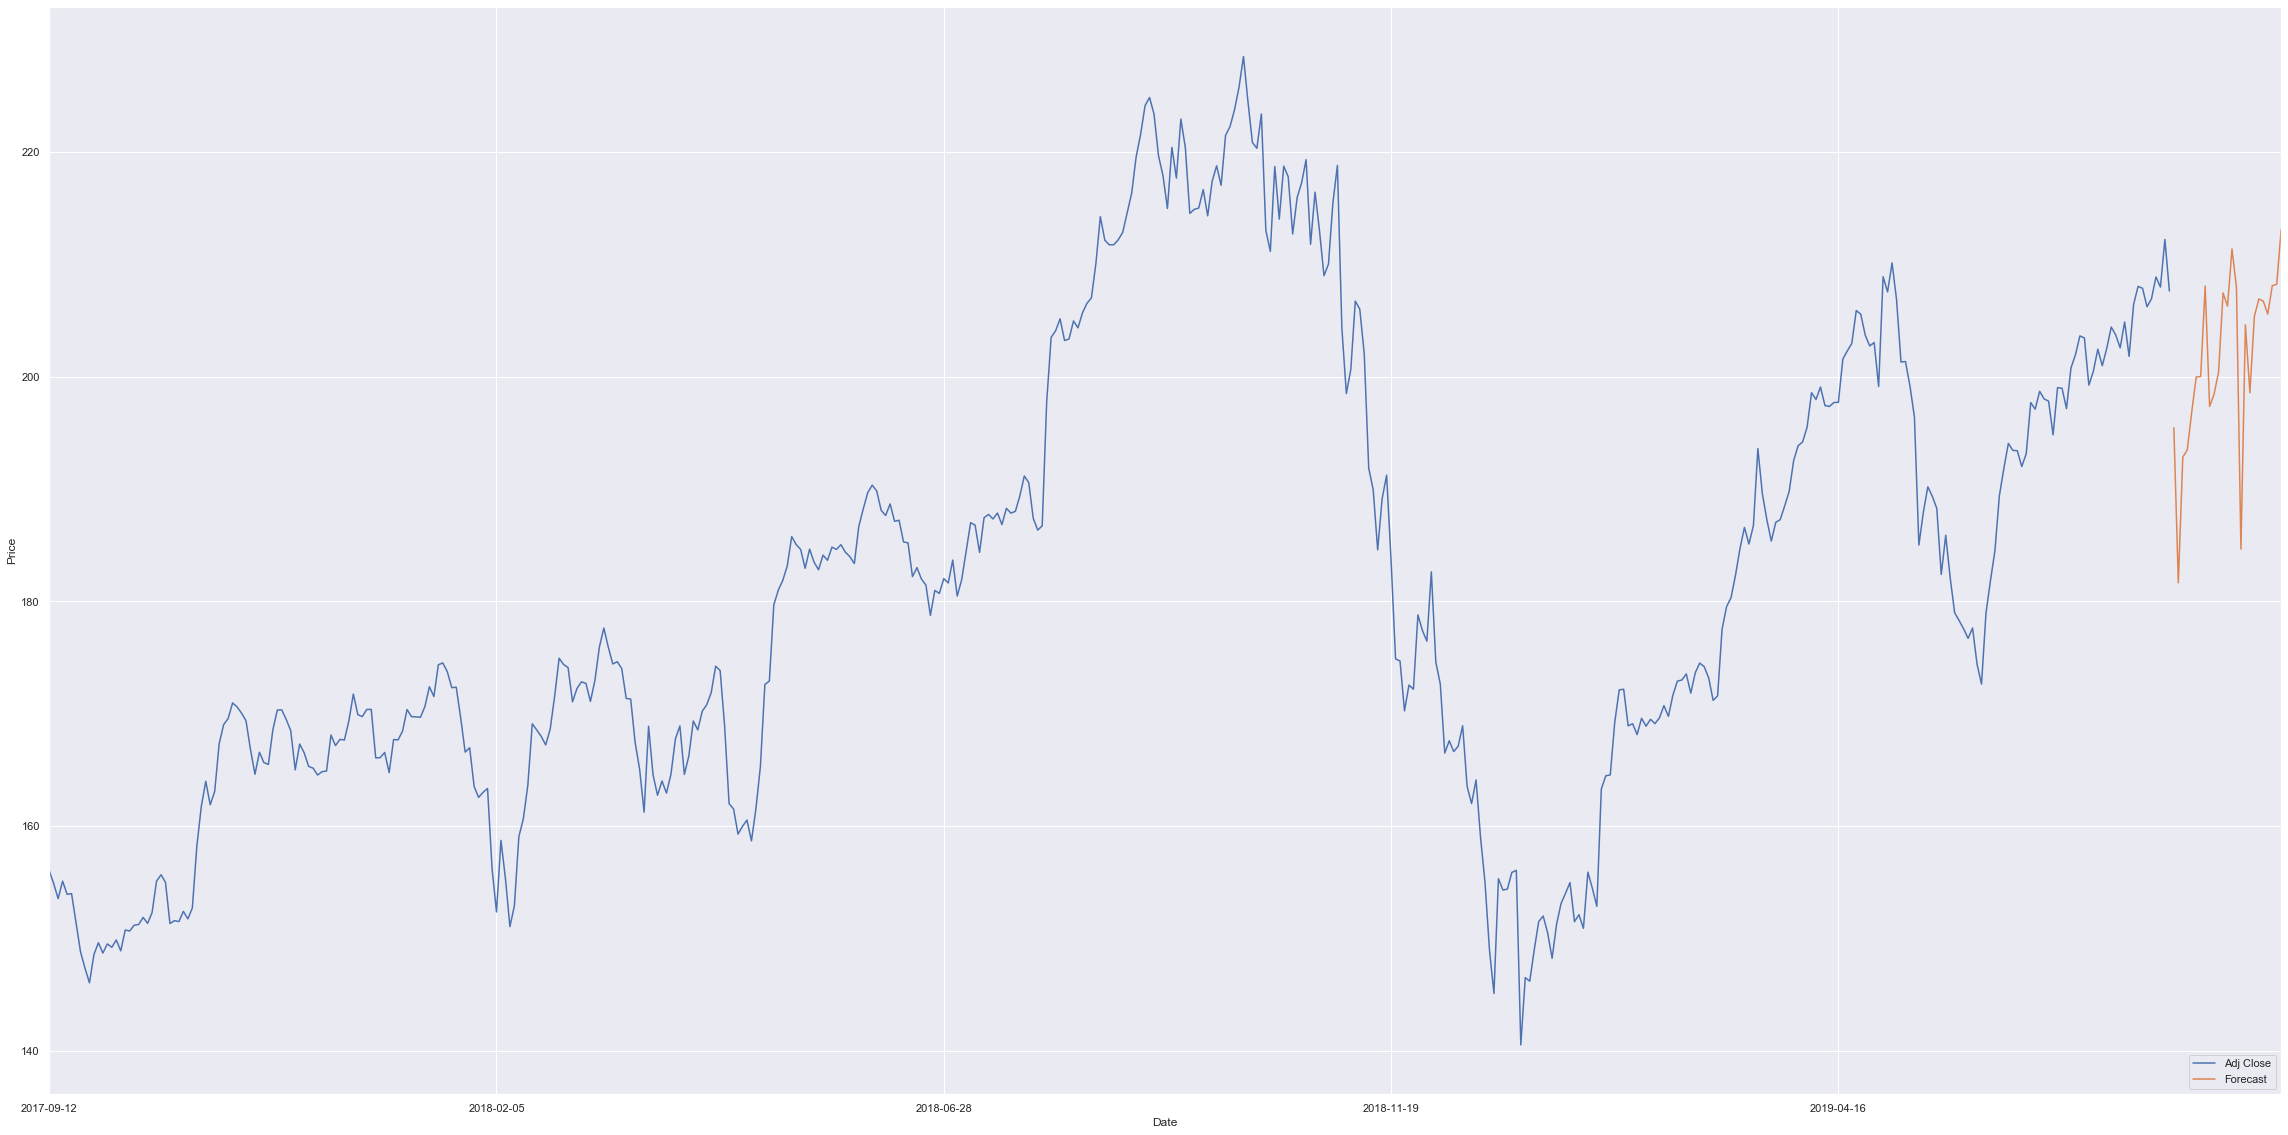

In [14]:
# Plotting Quadratic Regression 3
dfc['Adj Close'].tail(500).plot() 
dfc['Forecast'].tail(500).plot()  
plt.rcParams["figure.figsize"] = (40,20)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [15]:
# Lasso predictions
clf = clflso  
dfc = dfreg
forecast_set = clf.predict(X_lately)
dfc['Forecast'] = np.nan

last_date = dfc.iloc[-1].name
forecast_days = forecast_out *7/5

fc_idx = int(len(dfc)-forecast_out)
fc_unix = dfc.iloc[int(fc_idx)].name

for i in forecast_set:
    next_date = dfc.iloc[int(fc_idx)].name
    dfc.loc[next_date] = [np.nan for _ in range(len(dfc.columns)-1)]+[i]
    fc_idx += 1

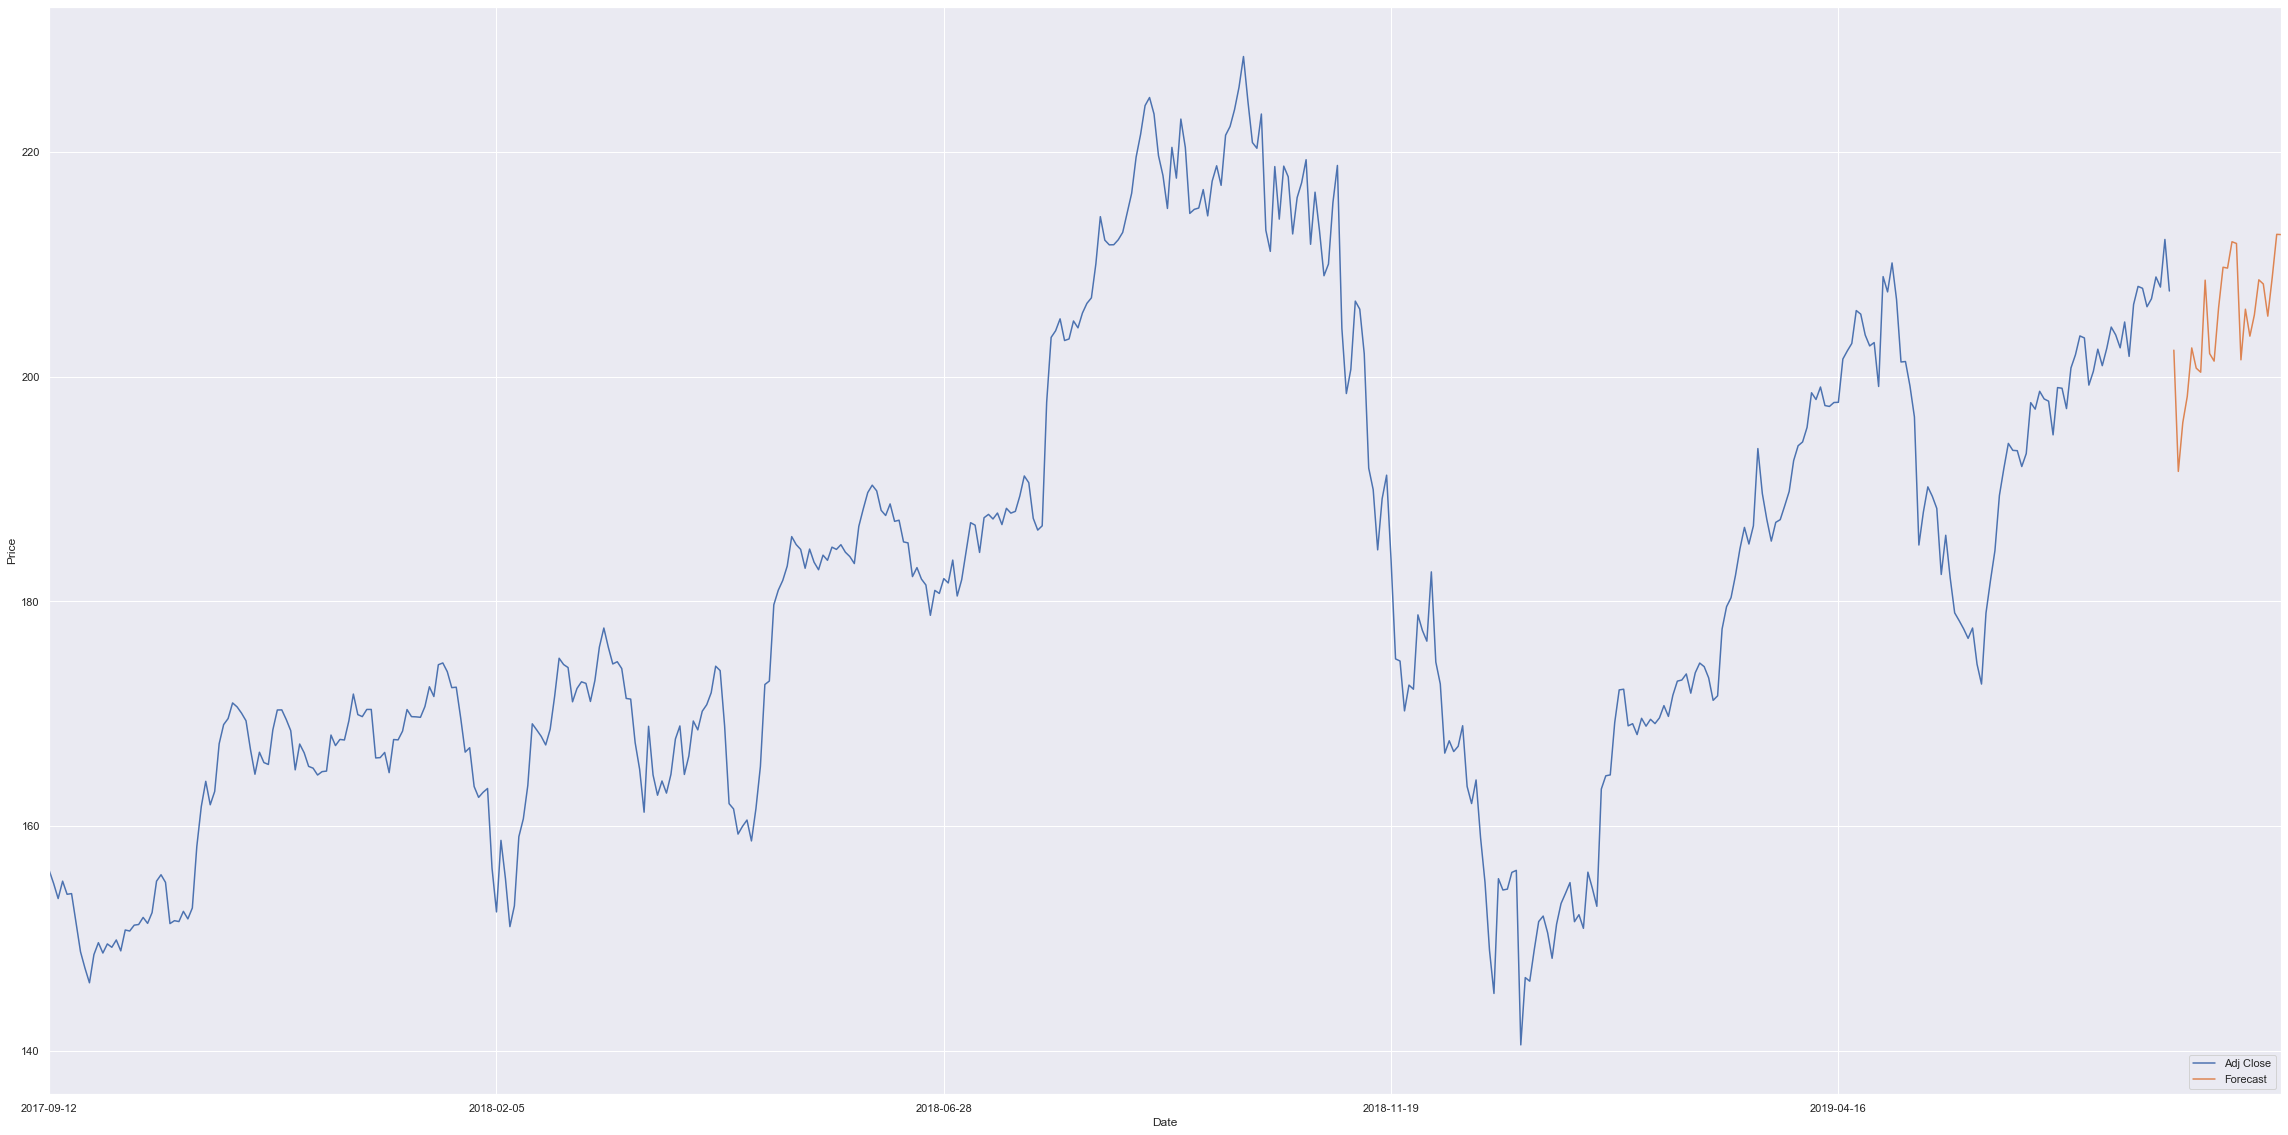

In [16]:
# Plotting Lasso
dfc['Adj Close'].tail(500).plot() 
dfc['Forecast'].tail(500).plot()  
plt.rcParams["figure.figsize"] = (40,20)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()